[View in Colaboratory](https://colab.research.google.com/github/jgarci135/Kaggle/blob/master/Dog_Classification_Joshua_Garcia.ipynb)

In [80]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmp2n_de3xp/pubring.gpg' created
gpg: /tmp/tmp2n_de3xp/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [82]:
#@title Default title text
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use the competition. once this is run there is no longer a need to run again. The directory should be present in the Google Drive
!mkdir -p /content/drive/competition/

In [5]:
!ls /content/drive/competition/ 

colab_test.ipynb  labels.csv		 testdata.hdf5	 train_valid_test
colabtest.ipynb   sample_submission.csv  train
dogweight.h5	  test			 traindata.hdf5


In [0]:
import os
import time
import cv2
import pandas as pd
%matplotlib inline
import matplotlib
import numpy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import random
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from collections import Counter
import math
import shutil
import keras 
import h5py
import glob
from keras.utils import to_categorical
import PIL
 
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, Image
from IPython.core.display import HTML
 
%matplotlib inline

In [0]:
#Create train and test paths. pointers created on local
train_path = os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/train/')
test_path = os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/test')

In [0]:
#Create train and test paths. pointers created for Google drive
train_path = os.path.join('/content/drive/competition/train/')
test_path = os.path.join('/content/drive/competition/test/')

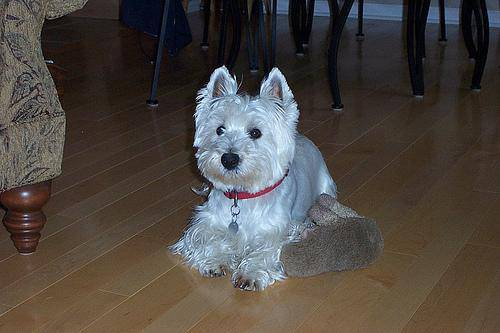

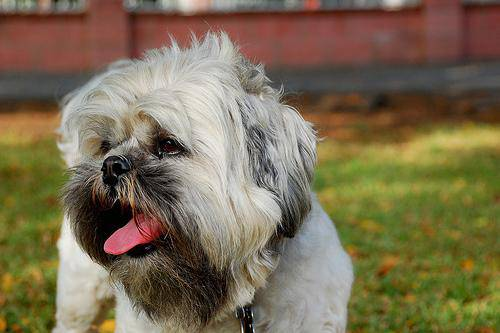

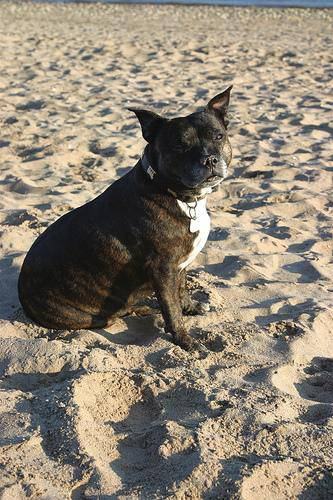

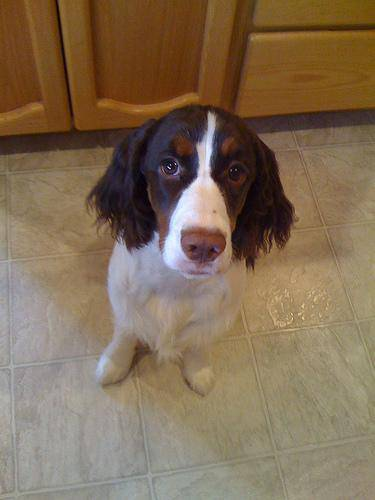

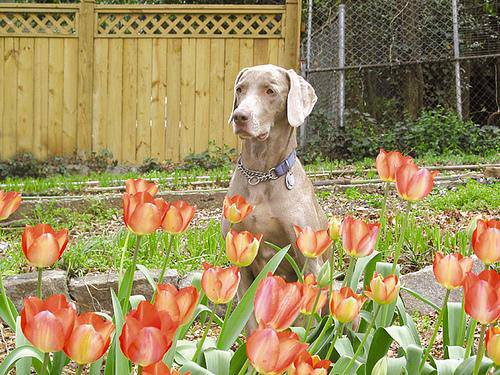

In [0]:
#Examine the files in train folder.
n_train = len(os.listdir(train_path))
sample_idxs = np.random.choice(n_train, 5, replace=False)
 
for idx in sample_idxs:
# Choose a random file from the training data directory.
    filename = os.listdir(train_path)[idx]
 
# Display the image contained in the chosen file.
    image = Image(os.path.join(train_path, filename))
    display(image)

In [0]:
#sort the training and test files.
train_files = sorted(glob.glob(train_path+'*.jpg'))
test_files = sorted(glob.glob(test_path+'*.jpg'))

In [87]:
#Examine train files after sorting
train_files

['/content/drive/competition/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/competition/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/competition/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/competition/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/competition/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/competition/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/competition/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 ...]

In [97]:
#Show number of files in the training file path.
len(train_files)

10259

In [98]:
c0 = plt.imread(train_files[0]) #read file path to an image, now c0 is a numpy image
print(c0.shape)

(375, 500, 3)


In [0]:
#Define a function to resize the images to uniformity with cv2
def rescale(im):
    return cv2.resize(im, (128,128), interpolation = cv2.INTER_AREA)
#Call function to create the vector from train data
X=[]
for train in train_files:
    X.append(rescale(plt.imread(train)))

In [0]:
#Create a numpy array and print the shape from the vector of images. (This method was compared but not used to one used later in notebook)
X = np.array(X)
print(X.shape)

(10222, 128, 128, 3)


In [0]:
#Print information about X
print(X.dtype)
print(X.mean())
print(X.max())
print(X.min())
print(X.nbytes/10**9) #size of file in GB

uint8
112.29569887606465
255
0
0.502431744


In [0]:
#X not used later and was deleted
del X

In [30]:
!ls '/content/drive/competition/'

colab_test.ipynb  sample_submission.csv  train
colabtest.ipynb   test			 traindata.hdf5
labels.csv	  testdata.hdf5		 train_valid_test


In [0]:
#Create labels from CSV. Used after loaded to Colab and needed differing path. First path refelcted local machine path.
train_labels_path = os.path.join('/content/drive/competition/','labels.csv')
train_labels = pd.read_csv(train_labels_path)

In [0]:
# Get the number of training, testing data.
n_train, n_test = len(os.listdir(train_path)), len(os.listdir(test_path))
 
# Print them out!
print('No. training data:', n_train)
print('No. test data:', n_test)

No. training data: 10222
No. test data: 10357


In [0]:
# Load the training data labels using pandas (for .csv files, it's quite fast). This is the version for local computer.
train_labels_path = os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/','labels.csv')
train_labels = pd.read_csv(train_labels_path)
 
# Show the first 10 lines of the DataFrame containing fields "id" and "breed".
train_labels.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [0]:
# Use the DataFrame function `describe` function to see a short summary of the data.
train_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,814a9fc5db2614bbe59328c16496b50e,scottish_deerhound
freq,1,126


In [0]:
def read_img(ID, train=True, size=(128, 128)):
  """
  Read and resize a single image.
 
  - Arguments:
  ID (str): ID of image to be read.
  train (bool): Whether this is a training or test image.
  size (tuple(int)): The new size of the image.
 
  - Returns:
  Image as numpy.ndarray.
  """
  # Get the image from disk using pillow.
  if train:
    image = PIL.Image.open(os.path.join(train_path, '%s.jpg' % ID))
  else:
    image = PIL.Image.open(os.path.join(test_path, '%s.jpg' % ID))
 
  # Cast the Pillow image to a numpy.ndarray and return it.
  image = np.array(image.resize(size))
  return image

In [0]:
# Create an array of shape (n, W, H, D) containing all the training data.
X_train = np.array([ read_img(ID.split('.')[0]) for ID in sorted(os.listdir(train_path)) ])
 
print('Shape of training data (n, W, H, D):', X_train.shape)
 
# Save out the pre-processed training, validation data to disk.
np.save(os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/', 'X_train.npy'), X_train)
 
del X_train

Shape of training data (N, W, H, D): (10222, 128, 128, 3)


In [0]:
# Create a mapping from dog breeds categories to unique integer labels.
breeds = sorted(train_labels['breed'].unique())
class_map = { breed : idx for idx, breed in enumerate(breeds) }
inverse_class_map = { idx : breed for breed, idx in class_map.items()}

In [0]:
# Create a 1D array of shape (n,) contained all the training labels.
y_train = np.array([ class_map[train_labels[train_labels['id'] == ID.split('.')[0]]['breed'].tolist()[0]] for  ID in sorted(os.listdir(train_path)) ])
  
 
print('Shape of training labels (n,):', y_train.shape)
 
# Save out the pre-processed training, validation labels to disk.
np.save(os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/', 'y_train.npy'), y_train)
 
del y_train

Shape of training labels (N, K): (10222,)


In [0]:
# Create an array of shape (n, W, H, D) containing all the training data.
X_test = np.array([ read_img(ID.split('.')[0], train=False) for ID in sorted(os.listdir(test_path)) ])
 
print('Shape of test data (n, W, H, D):', X_test.shape)
 
# Save out the pre-processed training data to disk.
np.save(os.path.join('/Users/Family/Documents/Kaggle/Dog breed id/', 'X_test.npy'), X_test)
 
del X_test

Shape of test data (N, W, H, D): (10357, 128, 128, 3)


In [0]:
#Each of the numpy arrays must be loaded again for futher processing
y_train = np.load('/Users/Family/Documents/Kaggle/Dog breed id/y_train.npy')
X_train = np.load('/Users/Family/Documents/Kaggle/Dog breed id/X_train.npy')
X_test = np.load('/Users/Family/Documents/Kaggle/Dog breed id/X_test.npy')



In [0]:
#Encode y to categoical
Y = to_categorical(y_train)
print('Number of samples, categories',Y.shape)

(10222, 120)


In [0]:
# Shuffle training data. It's good to use index shuffling.
ind = np.array(list(range(10222)))
np.random.shuffle(ind)
print(ind[:10]) #check the shuffling


[ 577  228 3157 9970  476 1209 6284 7177 3054 7257]


In [0]:
#Shuffle the data
Xs = X_train[ind]
Yx = Y[ind]

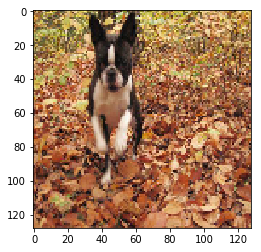

In [0]:
#Plot image 1 before shuffle
plt.imshow(X_train[0])

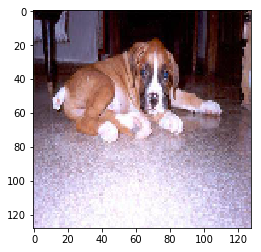

In [0]:
#Plot image 1 after shuffle (they should be different)
plt.imshow(Xs[0])

In [0]:
#The one hot encoded training should also be different from each other before and after shuffle.
print(Y[0], Yx[0]) 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
#Check data of train for comparison before data is normalized and changed to 32bit
print(X_train.dtype)
print(X_train.mean())
print(X_train.max())
print(X_train.min())
print(X_train.nbytes/10**9)

uint8
112.29633047827488
255
0
0.502431744


In [0]:
#Due to resource limits delete large varibles no longer needed(these are now used as Xs and Yx)
del X_train

del y_train

In [0]:
#Yx does not need to be normalized as it is categorical
del Yx

In [0]:
#Quick check that data type and max pixel value have not changed from X_train
print(Xs.dtype)
print(Xs.max())


uint8
255


In [0]:
#Normalization (file size quadurpaled)
Xs = (Xs-127.5)/255
print(Xs.dtype)
print(Xs.mean())
print(Xs.max())
print(Xs.min())
print(Xs.nbytes/10**9)

float64
-0.059622233418529555
0.5
-0.5
4.019453952


In [0]:
# Save disk space and change the dtype to float32
Xs = Xs.astype('float32')
print(Xs.dtype)
print(Xs.nbytes/10**9) # should be half the size in GB

float32
2.009726976


In [0]:
#Create a h5py file which is easy to use when saving and calling data sets
os.chdir('/Users/Family/Documents/Kaggle/Dog breed id/')
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs)
    f.create_dataset('Y', data=Yx)

In [0]:
#Normalize and change test data to match the train set.
#Check data in this block.
print(X_test.dtype)
print(X_test.mean())
print(X_test.max())
print(X_test.min())
print(X_test.nbytes/10**9)

uint8
112.01546919740649
255
0
0.509067264


In [0]:
#Simple normilization of X_test
X_test = (X_test-127.5)/255

In [0]:
#Change type from float64 to float 32 to save on file space and resource needs.
X_test = X_test.astype('float32')

In [0]:
#Check that test also has been normalized and file size reduced.
print(X_test.dtype)
print(X_test.mean())
print(X_test.max())
print(X_test.min())
print(X_test.nbytes/10**9)

float32
-0.06072371
0.5
-0.5
2.036269056


In [0]:
#Write test data set in hdf5 file.
os.chdir('/Users/Family/Documents/Kaggle/Dog breed id/')
with h5py.File('testdata.hdf5','w') as f:
    f.create_dataset('X_test', data=X_test)

In [0]:
#reading the file from Google Drive (in some cases the ".." can be removed)
os.chdir('../content/drive/competition/')
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][()] #the [()] means load all data (part of the data can be extracted from file by specifying - [:100])
   
    Y_train = f['Y'][()] 

with h5py.File('testdata.hdf5', 'r') as f:
    X_test = f['X_test'][()]

In [0]:


# fix random seed for reproducibility
seed = 123
numpy.random.seed(seed)


In [0]:
#Define inception to be used in model Used published configuration for incudption module
def inception2BN(x, n = 32):
    conv1 = Conv2D(n, 1, padding='same')(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv2 = Conv2D(n, 1, padding='same')(x)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(n, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)    
    conv3 = Conv2D(n, 1, padding='same')(x)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)    
    conv3 = Conv2D(n, 5, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)  
    conv4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    conv4 = Conv2D(n, 1, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)     

    c =  Concatenate(axis=-1)([conv1,conv2,conv3,conv4])
    return c

In [0]:
#Model with three layers
def model3():
    inputs = Input(X_train.shape[1:])
    i1 = inception2BN(inputs)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception2BN(mp1)
    mp2 = MaxPooling2D((2,2))(i2) 
    i3 = inception2BN(mp2)
    mp3 = MaxPooling2D((2,2))(i3)
    i4 = inception2BN(mp2)
    mp4 = MaxPooling2D((2,2))(i4)
    f = Flatten()(mp4)
    d = Dense(256)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    out = Dense(120, activation='softmax')(d)
    model = Model(inputs, out)
    return model

In [43]:
print(X_train.shape[:])

(10222, 128, 128, 3)


In [44]:
print(X_test.shape[:])

(10357, 128, 128, 3)


In [46]:
print(Y_train.shape[:])

(10222, 120)


In [0]:
model3 = model3()
adam = Adam(lr=0.001)
#load checkpoint
os.chdir('/content/drive/competition/')#Change directory to where the saved weights file is located
#model3.load_weights('dogweight.h5')
model3.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

#checkpoint
checkpoint = ModelCheckpoint('dogweight.h5', monitor='val_loss', save_best_only=True, mode='max')
cb = [checkpoint]

# Fit the model
t0=time.time()
log3 = model3.fit(X_train, Y_train, validation_split=0.25, epochs=20, callbacks=cb, batch_size=64, verbose=2)
t1=time.time()
print(t1-t0," seconds")


import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

Train on 7666 samples, validate on 2556 samples
Epoch 1/20
 - 94s - loss: 4.5614 - acc: 0.0459 - val_loss: 4.3612 - val_acc: 0.0563
Epoch 2/20
 - 84s - loss: 3.5527 - acc: 0.2005 - val_loss: 4.5032 - val_acc: 0.0712
Epoch 3/20
 - 84s - loss: 2.2200 - acc: 0.5830 - val_loss: 4.7246 - val_acc: 0.0552
Epoch 4/20
 - 84s - loss: 0.5668 - acc: 0.9562 - val_loss: 4.3756 - val_acc: 0.0704
Epoch 5/20


In [0]:
#Create prediction using model against the X_test
X_test_pred = model3.predict(X_test, verbose=0)


In [0]:
#create prediction file for submission
pred = pd.DataFrame(X_test_pred, index = test_files, columns=breeds)
pred.to_csv('dogbreed_subm.csv',index=True)